Student: Luiz Augusto Facury de Souza

* According to the poly, to model a SIR process, we need to consider the differential system of unknown functions $x(t) = (s(t), i(t), r(t))$:

1) $s'(t) = -\beta s(t) i(t)$

2) $i'(t) = \beta s(t) i(t) - \gamma i(t)$

3) $r'(t) = \gamma i(t)$

With the constraints $s(t) > 0$, $i(t) > 0$ and $r(t) > 0$ and initial conditions $s(0) \geq 0$, $i(0) > 0$ and $r(0) \geq 0$.

We also know from the poly that $S(t) + I(t) + R(t) = N+1$ and, in the initial state, $S(t) = N, I(t) = 1, R(t) = 0$. That is, there is only one infected person in the initial state. With this, we can define the parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="colorblind", style="darkgrid")
from scipy.integrate import odeint
import pandas as pd

N = 999 + 1 # Population
s0 = N - 1 # Initial susceptible
i0 = 1 # Initial infected
r0 = 0 # Initial recovered
beta = 3 # Contagion rate
gamma = 1.5 # Recovery rate


Defining the initial states and the differential equation, we can use a function to solve the system. In this case, we will use the function odeint from scipy.integrate:

The function odeint receives as parameters the differential equation, the initial states, the time vector and other arguments. The output is a matrix with the values of the states in each time step. We can use the model present in the documentation of odeint to define the function that will be used to solve the system and plot the results:


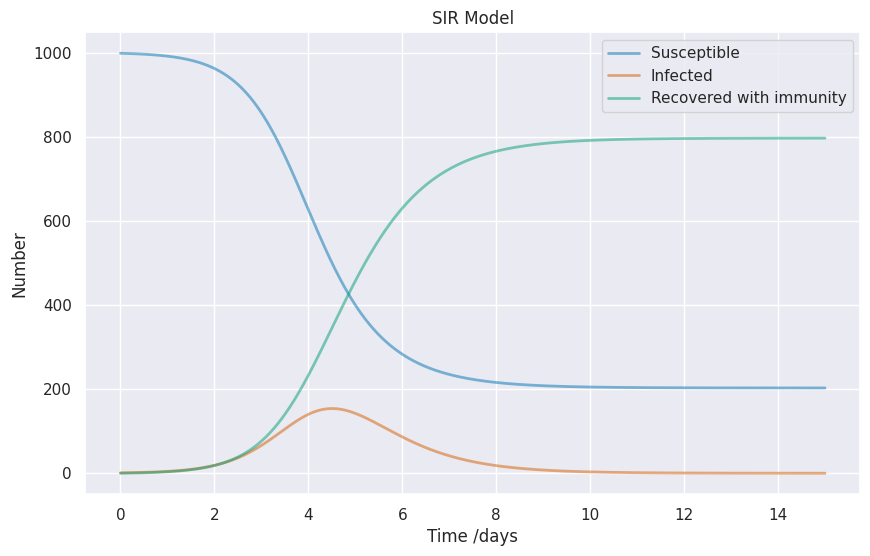

In [2]:
#Define differential equations for SIR model
def SIR(y, t, N, beta, gamma):
    s = y[0]
    i = y[1]
    r = y[2]

    dsdt = -beta * s * i / N
    didt = beta * s * i / N - gamma * i
    drdt = gamma * i

    return dsdt, didt, drdt

t = np.linspace(0, 15, 2000)
y = (s0, i0, r0)
sol = odeint(SIR, y, t, args=(N, beta, gamma))
s, i, r = sol.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(t, s, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, i, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, r, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
plt.xlabel('Time /days')
plt.ylabel('Number')
plt.title('SIR Model')
plt.legend()
plt.show()
    

* To construct the markov model, we need to change the meaning of the parameter $\beta$, which will now be the rate of encounters with susceptible, recovered or infected people. This way, when the duration of the infection is exponentially distributed with mean $\frac{1}{\gamma}$, the process X = (S, I, R) is a Markov chain process that admits the following transitions:

1) $(s, i, r) \rightarrow (s-1, i+1, r)$ with rate $\beta N^{-1} i s 1_{\{s > 0\}}$

2) $(s, i, r) \rightarrow (s, i-1, r+1)$ with rate $\gamma i 1_{\{i > 0\}}$

In fact, the rate of new infection attempts is given by $\beta i$, and each infectious person has a probability of $\frac{s}{N}$ of encountering a susceptible person. Thus, the rate of new infections is the product of these two quantities, that is, $\frac{\beta i s}{N}$ if the number of susceptible people is greater than zero.

Each infectious person has a probability of $\gamma$ of recovering, so the exit rate of at least one infectious person is $\gamma i$.

Knowing those rates, we can define the model:

In [3]:
new_infections = lambda s, i, beta, N: beta * s * i / N +1e-5
new_recoveries = lambda i, gamma: gamma * i 


def draw_and_update (current, beta, gamma, flag=False):
    state = current.copy()
    N = np.sum(state)
    #Define the vector of rates
    lambdas = np.array([new_infections(state[0], state[1], beta, N), new_recoveries(state[1], gamma)])
    time = np.random.exponential(1/np.sum(lambdas))
    
    #Compute the threshold for the draw
    p = lambdas[0] / lambdas.sum()

    # Draw the next state
    next = np.random.choice([0, 1], p=[p, 1-p])
    #0 = infection, 1 = recovery
    # Update the state
    if next == 0 and state[0] > 0: #Add a new infection
        state[0] -= 1
        state[1] += 1
    elif next == 1 and state[1] > 0 and not flag: #Add a new recovery
        state[1] -= 1
        state[2] += 1
    
    return time, state

def simulate (init, beta, gamma, T):
    state = init.copy()
    states = [state]
    times = [0]
    a = 0
    c = []
    first = True
    #Run the simulation until the time T
    while times[-1] < T:
        time, new = draw_and_update(states[-1], beta, gamma, flag=first)
        first = False

        states.append(new)
        times.append(times[-1] + time)
    return np.array(states), np.array(times)

In [4]:
init = np.array([N-1, 1, 0]) # Initial conditions vector, of shape [S0, I0, R0]
beta = 3
gamma = 1.5
states, time = simulate(init, beta, gamma, 15)

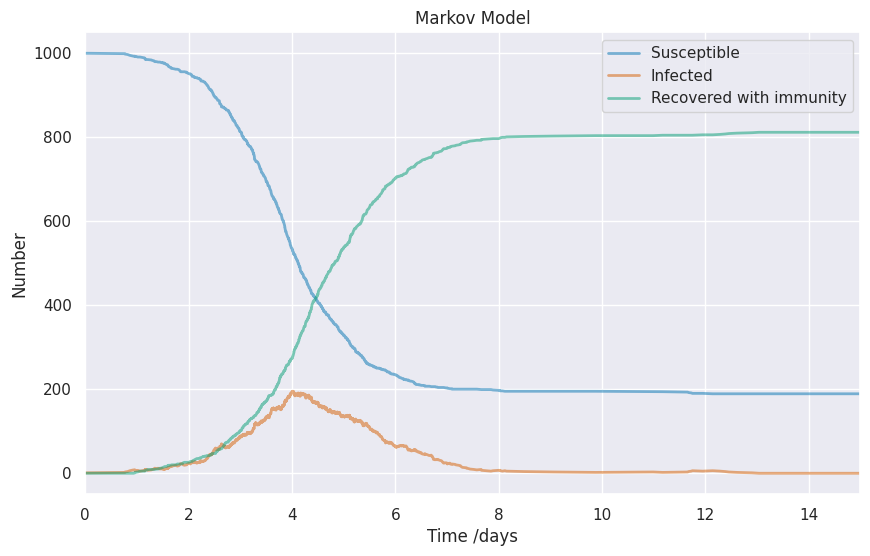

In [5]:
fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(time, states[:, 0], 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(time, states[:, 1], 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(time, states[:, 2], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
plt.xlim(0, 15)
plt.xlabel('Time /days')
plt.ylabel('Number')
plt.title('Markov Model')
plt.legend()
plt.show()


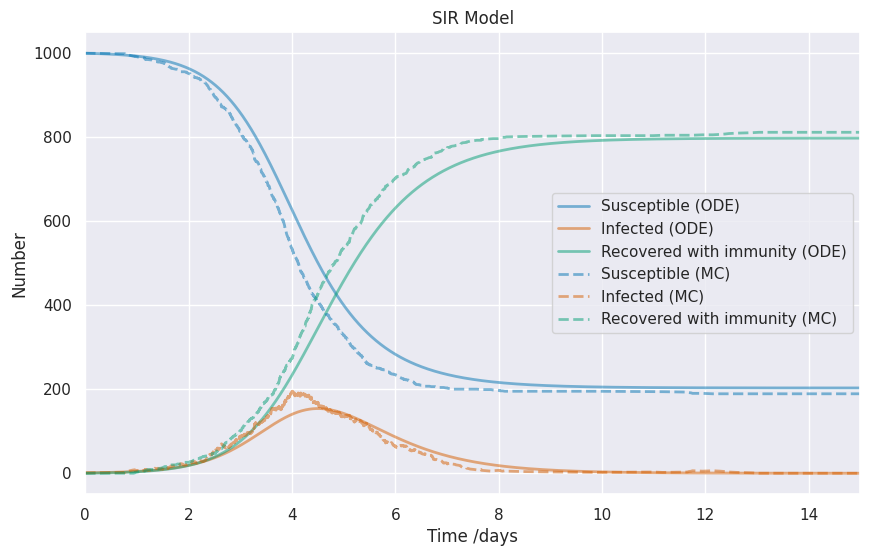

In [6]:
#Comparing the two models
fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(t, s, 'b', alpha=0.5, lw=2, label='Susceptible (ODE)')
plt.plot(t, i, 'r', alpha=0.5, lw=2, label='Infected (ODE)')
plt.plot(t, r, 'g', alpha=0.5, lw=2, label='Recovered with immunity (ODE)')
plt.plot(time, states[:, 0], 'b--', alpha=0.5, lw=2, label='Susceptible (MC)')
plt.plot(time, states[:, 1], 'r--', alpha=0.5, lw=2, label='Infected (MC)')
plt.plot(time, states[:, 2], 'g--', alpha=0.5, lw=2, label='Recovered with immunity (MC)')
plt.xlim(0, 15)
plt.xlabel('Time /days')
plt.ylabel('Number')
plt.title('SIR Model')
plt.legend()
plt.show()


We can see that the values are very close, altough the states returned by the markov model can vary a lot, since it is not deterministic. Sometimes, it yields a result significantly different from the deterministic model. In addition, we have to take into account that we have to deal with overflows in the markov model, since there are division by 0 when the number of infected or susceptible people is 0. To avoid it, I added a small value to the denominator before normalizing the rates, but another option woul be to end the simulation when the number of infected or susceptible people is 0, since the process will not change anymore.

* To find values for $\beta$ and $\gamma$ that make everyone recovered, we can either increase the value of $\beta$ or decrease the value of $\gamma$. When we increase the value of $\beta$, we increase the rate of new infections, which means that people will be infected faster and, therefore, more people will recover in a short time. When we decrease the value of $\gamma$, we decrease the rate of recovery, which means that people will take longer to recover and, therefore, more people will be infected in a short time. In both cases, the number of people infected will tend to increase, but the number of people recovered will also increase. Thus, we can find values for $\beta$ and $\gamma$ that make everyone recovered.

* To find values in which there are still people susceptible and recovered, we need to find less agressive values (a $\beta$ that is not so high and a $\gamma$ that is not so low). We can see the comparison in the following code and plot.

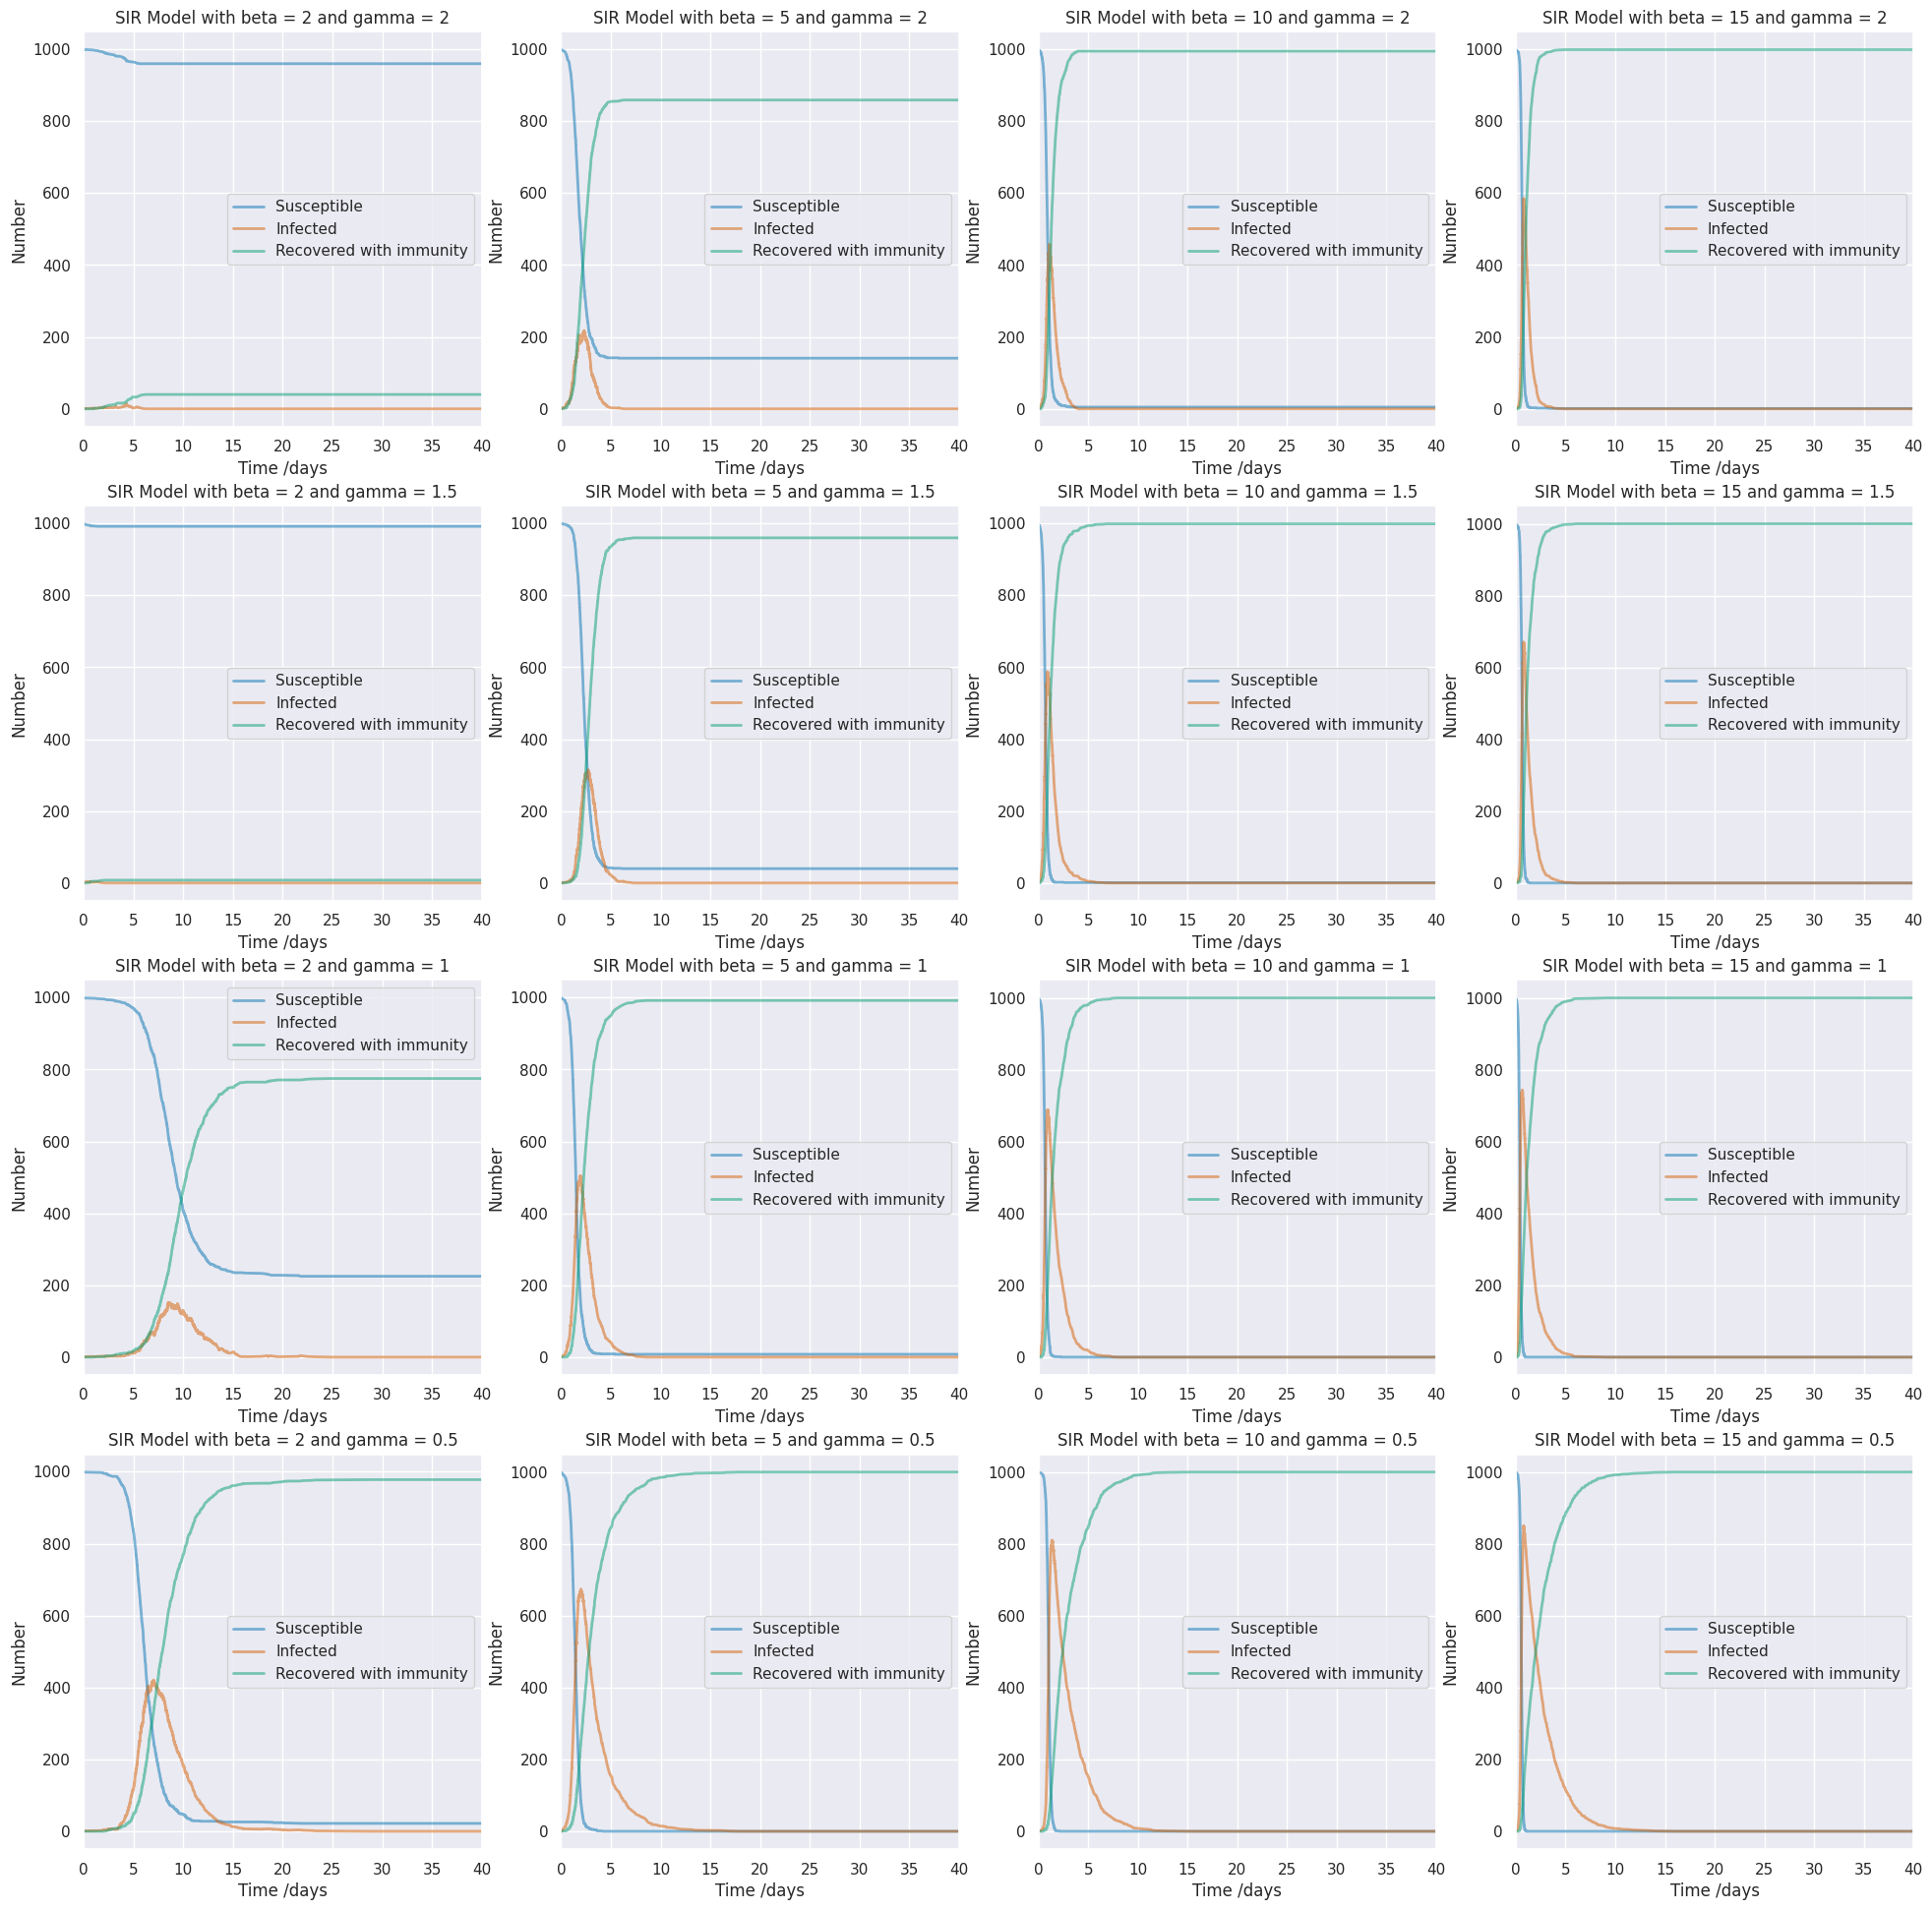

In [7]:
init = np.array([N-1, 1, 0]) # Initial conditions vector, of shape [S0, I0, R0]
beta = [2, 5, 10, 15]
gamma = [2, 1.5, 1, 0.5]
fig, axs = plt.subplots(4, 4, figsize=(24, 24))
d = {
    'gamma': [],
    'beta': [],
    'recovered': []
}


for c, g in enumerate(gamma):
    for b, be in enumerate(beta):
        states, time = simulate(init, be, g, 40)
        axs[c, b].plot(time, states[:, 0], 'b', alpha=0.5, lw=2, label='Susceptible')
        axs[c, b].plot(time, states[:, 1], 'r', alpha=0.5, lw=2, label='Infected')
        axs[c, b].plot(time, states[:, 2], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
        axs[c, b].set_xlim(0, 40)
        axs[c, b].set_xlabel('Time /days')
        axs[c, b].set_ylabel('Number')
        axs[c, b].set_title('SIR Model with beta = {} and gamma = {}'.format(be, g))
        axs[c, b].legend()
        d['beta'].append(be)
        d['gamma'].append(g)
        d['recovered'].append(states[-1, 2])
#plt.show()



In [8]:
df = pd.DataFrame(d)
df

,gamma,beta,recovered
0,2.0,2,40
1,2.0,5,859
2,2.0,10,995
3,2.0,15,999
4,1.5,2,8
5,1.5,5,960
6,1.5,10,999
7,1.5,15,1000
8,1.0,2,775
9,1.0,5,992


We can cleary see from the results that the simulation that have high $\beta$ and low $\gamma$ have more people recovered than the simulation that have low $\beta$ and high $\gamma$.

In [9]:
data = pd.read_csv('donnees-covid.csv', sep=';')
data

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,1,2020-03-19,1,0,0,0
1,1,2020-03-20,0,0,0,1
2,1,2020-03-21,3,0,0,0
3,1,2020-03-22,3,1,0,1
4,1,2020-03-23,14,1,0,5
...,...,...,...,...,...,...
26659,976,2020-12-03,0,0,0,1
26660,976,2020-12-04,0,0,0,0
26661,976,2020-12-05,0,1,0,3
26662,976,2020-12-06,0,0,0,0


Using this data, we can make an assumption that the infected (I) can be related to 'inicid_hosp' + 'incid_rea', since they are the people that we know for sure that are infected.In addition, the recovered (R) can be related to 'incid_dc' and 'incid_rad'.

Using this assumption, we can find the values of $\beta$ and $\gamma$ for each departament of the hospital using the equation that we used for the deterministic model, being S the number of people that are not infected in the departament.

For example, we can find $\gamma$ using the equation $r'(t) = \gamma i(t)$. If we compute the integral, we already have I and R, so we can find the parameter $\gamma$.

Finally, there is a system of the 2 equations, which we can integrate to find $\beta$ and S for each departament in the hospital in each day.

